## 05 - Otimização de Hiperparâmetros e Predições Finais
1. Otimização de hiperparâmetros (Grid Search)
2. Treinamento do modelo otimizado
3. Predições no conjunto de validação
4. Comparação com modelos base

# Imports

In [1]:
import sys
sys.path.append('/home/jovyan/work')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from src import S3Client, ModelTrainer, ModelEvaluator, MLFlowClient, DatabaseClient

# Carregamento dos dados

In [2]:
s3 = S3Client()

X_train = s3.read_csv('processed/X_train_scaled.csv')
y_train = s3.read_csv('processed/y_train.csv')['target']
X_test = s3.read_csv('processed/X_test_scaled.csv')
y_test = s3.read_csv('processed/y_test.csv')['target']
X_val = s3.read_csv('processed/X_val_scaled.csv')
y_val = s3.read_csv('processed/y_val.csv')['target']

print(f"📊 Train: {X_train.shape}")
print(f"📊 Test: {X_test.shape}")
print(f"📊 Validation: {X_val.shape}")

INFO:src.s3_utils:S3 Client inicializado: http://minio:9000/ml-bucket-heart
INFO:src.s3_utils:✅ CSV lido: s3://ml-bucket-heart/processed/X_train_scaled.csv (602 linhas)
INFO:src.s3_utils:✅ CSV lido: s3://ml-bucket-heart/processed/y_train.csv (602 linhas)
INFO:src.s3_utils:✅ CSV lido: s3://ml-bucket-heart/processed/X_test_scaled.csv (232 linhas)
INFO:src.s3_utils:✅ CSV lido: s3://ml-bucket-heart/processed/y_test.csv (232 linhas)
INFO:src.s3_utils:✅ CSV lido: s3://ml-bucket-heart/processed/X_val_scaled.csv (227 linhas)
INFO:src.s3_utils:✅ CSV lido: s3://ml-bucket-heart/processed/y_val.csv (227 linhas)


📊 Train: (602, 19)
📊 Test: (232, 19)
📊 Validation: (227, 19)


# Inicialização

In [3]:
trainer = ModelTrainer()
evaluator = ModelEvaluator()
mlflow_client = MLFlowClient(experiment_name="heart-disease-hyperparameter-tuning")

INFO:src.model_training:ModelTrainer inicializado
INFO:src.model_evaluation:ModelEvaluator inicializado
INFO:src.mlflow_utils:✅ Experimento criado: heart-disease-hyperparameter-tuning
INFO:src.mlflow_utils:MLFlow Client inicializado: http://mlflow:5000


## Parte 1: Otimização de Hiperparâmetros

### Random Forest - Grid Search

In [4]:
print("🔄 Otimizando Random Forest...")

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Modelo base
rf_base = trainer.get_model('random_forest')

# Grid Search
print(f"📊 Testando {np.prod([len(v) for v in rf_param_grid.values()])} combinações...")
print(f"⏱️  Isso pode levar alguns minutos...\n")

rf_tuned, rf_best_params = trainer.hyperparameter_tuning(
    model=rf_base,
    param_grid=rf_param_grid,
    X_train=X_train,
    y_train=y_train,
    cv=5,
    scoring='accuracy'
)

print(f"\n🏆 Melhores hiperparâmetros Random Forest:")
for param, value in rf_best_params.items():
    print(f"   {param}: {value}")

INFO:src.model_training:🤖 Modelo criado: random_forest com params: {'n_estimators': 100, 'random_state': 42}
INFO:src.model_training:🔄 Buscando melhores hiperparâmetros (GridSearchCV)...
INFO:src.model_training:📊 Grade: {'n_estimators': [100, 200, 300], 'max_depth': [10, 15, 20, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2']}


🔄 Otimizando Random Forest...
📊 Testando 216 combinações...
⏱️  Isso pode levar alguns minutos...

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


INFO:src.model_training:✅ Melhores params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
INFO:src.model_training:✅ Melhor score: 0.8572



🏆 Melhores hiperparâmetros Random Forest:
   max_depth: 10
   max_features: sqrt
   min_samples_leaf: 4
   min_samples_split: 10
   n_estimators: 200


### Logistic Regression - Grid Search

In [5]:
print("\n🔄 Otimizando Logistic Regression...")

lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000]
}

lr_base = trainer.get_model('logistic_regression')

print(f"📊 Testando {np.prod([len(v) for v in lr_param_grid.values()])} combinações...")

lr_tuned, lr_best_params = trainer.hyperparameter_tuning(
    model=lr_base,
    param_grid=lr_param_grid,
    X_train=X_train,
    y_train=y_train,
    cv=5,
    scoring='accuracy'
)

print(f"\n🏆 Melhores hiperparâmetros Logistic Regression:")
for param, value in lr_best_params.items():
    print(f"   {param}: {value}")

INFO:src.model_training:🤖 Modelo criado: logistic_regression com params: {'max_iter': 1000, 'random_state': 42}
INFO:src.model_training:🔄 Buscando melhores hiperparâmetros (GridSearchCV)...
INFO:src.model_training:📊 Grade: {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga'], 'max_iter': [1000]}



🔄 Otimizando Logistic Regression...
📊 Testando 24 combinações...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 


🏆 Melhores hiperparâmetros Logistic Regression:
   C: 0.1
   max_iter: 1000
   penalty: l1
   solver: liblinear


### SVM - Grid Search

In [6]:
print("\n🔄 Otimizando SVM...")

svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['rbf', 'poly']
}

svm_base = trainer.get_model('svm')

print(f"📊 Testando {np.prod([len(v) for v in svm_param_grid.values()])} combinações...")
print("⚠️  SVM pode demorar mais...")

svm_tuned, svm_best_params = trainer.hyperparameter_tuning(
    model=svm_base,
    param_grid=svm_param_grid,
    X_train=X_train,
    y_train=y_train,
    cv=5,
    scoring='accuracy'
)

print(f"\n🏆 Melhores hiperparâmetros SVM:")
for param, value in svm_best_params.items():
    print(f"   {param}: {value}")

INFO:src.model_training:🤖 Modelo criado: svm com params: {'kernel': 'rbf', 'probability': True, 'random_state': 42}
INFO:src.model_training:🔄 Buscando melhores hiperparâmetros (GridSearchCV)...
INFO:src.model_training:📊 Grade: {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto', 0.001, 0.01, 0.1], 'kernel': ['rbf', 'poly']}



🔄 Otimizando SVM...
📊 Testando 40 combinações...
⚠️  SVM pode demorar mais...
Fitting 5 folds for each of 40 candidates, totalling 200 fits


INFO:src.model_training:✅ Melhores params: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
INFO:src.model_training:✅ Melhor score: 0.8505



🏆 Melhores hiperparâmetros SVM:
   C: 1
   gamma: 0.001
   kernel: rbf


### Gradient Boosting

In [7]:
print("\n🔄 Otimizando Gradient Boosting...")

gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

gb_base = trainer.get_model('gradient_boosting')

print(f"📊 Testando {np.prod([len(v) for v in gb_param_grid.values()])} combinações...")
print("⏱️  Gradient Boosting pode levar bastante tempo...")

gb_tuned, gb_best_params = trainer.hyperparameter_tuning(
    model=gb_base,
    param_grid=gb_param_grid,
    X_train=X_train,
    y_train=y_train,
    cv=5,
    scoring='accuracy'
)

print(f"\n🏆 Melhores hiperparâmetros Gradient Boosting:")
for param, value in gb_best_params.items():
    print(f"   {param}: {value}")

INFO:src.model_training:🤖 Modelo criado: gradient_boosting com params: {'n_estimators': 100, 'random_state': 42}
INFO:src.model_training:🔄 Buscando melhores hiperparâmetros (GridSearchCV)...
INFO:src.model_training:📊 Grade: {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.05, 0.1, 0.2], 'max_depth': [3, 5, 7, 9], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'subsample': [0.8, 0.9, 1.0]}



🔄 Otimizando Gradient Boosting...
📊 Testando 1296 combinações...
⏱️  Gradient Boosting pode levar bastante tempo...
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


INFO:src.model_training:✅ Melhores params: {'learning_rate': 0.2, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8}
INFO:src.model_training:✅ Melhor score: 0.8505



🏆 Melhores hiperparâmetros Gradient Boosting:
   learning_rate: 0.2
   max_depth: 7
   min_samples_leaf: 1
   min_samples_split: 2
   n_estimators: 200
   subsample: 0.8


### Random Forest Tuned

In [8]:
print("\n🔄 Otimizando Random Forest Tuned v2 (refinamento)...")

# Grade mais refinada baseada nos melhores parâmetros anteriores
rf_tuned_v2_param_grid = {
    'n_estimators': [250, 300, 350, 400],
    'max_depth': [15, 20, 25, None],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Usar o modelo já otimizado como base
rf_for_v2 = trainer.get_model('random_forest')

print(f"📊 Testando {np.prod([len(v) for v in rf_tuned_v2_param_grid.values()])} combinações...")
print("⏱️  Refinamento adicional...")

rf_tuned_v2, rf_v2_best_params = trainer.hyperparameter_tuning(
    model=rf_for_v2,
    param_grid=rf_tuned_v2_param_grid,
    X_train=X_train,
    y_train=y_train,
    cv=5,
    scoring='accuracy'
)

print(f"\n🏆 Melhores hiperparâmetros Random Forest Tuned v2:")
for param, value in rf_v2_best_params.items():
    print(f"   {param}: {value}")

INFO:src.model_training:🤖 Modelo criado: random_forest com params: {'n_estimators': 100, 'random_state': 42}
INFO:src.model_training:🔄 Buscando melhores hiperparâmetros (GridSearchCV)...
INFO:src.model_training:📊 Grade: {'n_estimators': [250, 300, 350, 400], 'max_depth': [15, 20, 25, None], 'min_samples_split': [2, 3, 5], 'min_samples_leaf': [1, 2], 'max_features': ['sqrt', 'log2', None], 'bootstrap': [True, False]}



🔄 Otimizando Random Forest Tuned v2 (refinamento)...
📊 Testando 576 combinações...
⏱️  Refinamento adicional...
Fitting 5 folds for each of 576 candidates, totalling 2880 fits


INFO:src.model_training:✅ Melhores params: {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 250}
INFO:src.model_training:✅ Melhor score: 0.8489



🏆 Melhores hiperparâmetros Random Forest Tuned v2:
   bootstrap: True
   max_depth: 15
   max_features: sqrt
   min_samples_leaf: 2
   min_samples_split: 2
   n_estimators: 250


## Parte 2: Avaliar Modelos Otimizados

In [9]:
tuned_models = {
    'random_forest_optimized': rf_tuned,
    'logistic_regression_optimized': lr_tuned,
    'svm_optimized': svm_tuned,
    'gradient_boosting_optimized': gb_tuned,
    'random_forest_tuned_v2': rf_tuned_v2
}

results_tuned = []

for name, model in tuned_models.items():
    print(f"\n🔄 Avaliando: {name}")
    
    # Predições
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None
    
    # Avaliar
    metrics = evaluator.evaluate_model(y_test, y_pred, y_pred_proba, model_name=name)
    results_tuned.append(metrics)
    
    print(f"   ✅ Accuracy: {metrics['accuracy']:.4f}")
    
    # Salvar modelo otimizado no MinIO
    model_id = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
    model_path = f'models/{name}/{model_id}/model.pkl'
    s3.save_model(model, model_path)
    print(f"   💾 Modelo salvo: {model_path}")
    
    # Log no MLFlow (apenas métricas e parâmetros, não o modelo)
    try:
        run = mlflow_client.start_run(run_name=f"tuned_{name}")
        mlflow_client.log_params(model.get_params())
        mlflow_client.log_metrics({
            'test_accuracy': metrics['accuracy'],
            'test_precision': metrics['precision'],
            'test_recall': metrics['recall'],
            'test_f1': metrics['f1_score']
        })
        mlflow_client.end_run()
    except Exception as e:
        print(f"   ⚠️ Erro ao logar no MLFlow: {str(e)}")

print("\n✅ Modelos otimizados avaliados e salvos!")

INFO:src.model_evaluation:📊 Avaliando modelo: random_forest_optimized
INFO:src.model_evaluation:✅ Accuracy: 0.8793
INFO:src.model_evaluation:✅ Precision: 0.8793
INFO:src.model_evaluation:✅ Recall: 0.8793
INFO:src.model_evaluation:✅ F1-Score: 0.8792
INFO:src.model_evaluation:✅ ROC AUC: 0.9345
INFO:src.s3_utils:✅ Modelo salvo: s3://ml-bucket-heart/models/random_forest_optimized/20251201_231251/model.pkl



🔄 Avaliando: random_forest_optimized
   ✅ Accuracy: 0.8793
   💾 Modelo salvo: models/random_forest_optimized/20251201_231251/model.pkl


INFO:src.mlflow_utils:🚀 Run iniciado: bce3afacbe7a4cfeb030f5f5694584f0
INFO:src.mlflow_utils:📝 Parâmetros registrados: 19 itens
INFO:src.mlflow_utils:📊 Métricas registradas: 4 itens
INFO:src.mlflow_utils:✅ Run finalizado
INFO:src.model_evaluation:📊 Avaliando modelo: logistic_regression_optimized
INFO:src.model_evaluation:✅ Accuracy: 0.8621
INFO:src.model_evaluation:✅ Precision: 0.8623
INFO:src.model_evaluation:✅ Recall: 0.8621
INFO:src.model_evaluation:✅ F1-Score: 0.8621
INFO:src.model_evaluation:✅ ROC AUC: 0.9256
INFO:src.s3_utils:✅ Modelo salvo: s3://ml-bucket-heart/models/logistic_regression_optimized/20251201_231251/model.pkl
INFO:src.mlflow_utils:🚀 Run iniciado: bfc5587b142f4ebb9ca8ddf530a7004f
INFO:src.mlflow_utils:📝 Parâmetros registrados: 15 itens
INFO:src.mlflow_utils:📊 Métricas registradas: 4 itens


🏃 View run tuned_random_forest_optimized at: http://mlflow:5000/#/experiments/14/runs/bce3afacbe7a4cfeb030f5f5694584f0
🧪 View experiment at: http://mlflow:5000/#/experiments/14

🔄 Avaliando: logistic_regression_optimized
   ✅ Accuracy: 0.8621
   💾 Modelo salvo: models/logistic_regression_optimized/20251201_231251/model.pkl
🏃 View run tuned_logistic_regression_optimized at: http://mlflow:5000/#/experiments/14/runs/bfc5587b142f4ebb9ca8ddf530a7004f
🧪 View experiment at: http://mlflow:5000/#/experiments/14


INFO:src.mlflow_utils:✅ Run finalizado
INFO:src.model_evaluation:📊 Avaliando modelo: svm_optimized
INFO:src.model_evaluation:✅ Accuracy: 0.8491
INFO:src.model_evaluation:✅ Precision: 0.8491
INFO:src.model_evaluation:✅ Recall: 0.8491
INFO:src.model_evaluation:✅ F1-Score: 0.8491
INFO:src.model_evaluation:✅ ROC AUC: 0.9193
INFO:src.s3_utils:✅ Modelo salvo: s3://ml-bucket-heart/models/svm_optimized/20251201_231251/model.pkl
INFO:src.mlflow_utils:🚀 Run iniciado: 4b4cb463cf7a4bffa057f90c788219e4
INFO:src.mlflow_utils:📝 Parâmetros registrados: 15 itens
INFO:src.mlflow_utils:📊 Métricas registradas: 4 itens



🔄 Avaliando: svm_optimized
   ✅ Accuracy: 0.8491
   💾 Modelo salvo: models/svm_optimized/20251201_231251/model.pkl
🏃 View run tuned_svm_optimized at: http://mlflow:5000/#/experiments/14/runs/4b4cb463cf7a4bffa057f90c788219e4
🧪 View experiment at: http://mlflow:5000/#/experiments/14


INFO:src.mlflow_utils:✅ Run finalizado
INFO:src.model_evaluation:📊 Avaliando modelo: gradient_boosting_optimized
INFO:src.model_evaluation:✅ Accuracy: 0.9138
INFO:src.model_evaluation:✅ Precision: 0.9140
INFO:src.model_evaluation:✅ Recall: 0.9138
INFO:src.model_evaluation:✅ F1-Score: 0.9138
INFO:src.model_evaluation:✅ ROC AUC: 0.9503
INFO:src.s3_utils:✅ Modelo salvo: s3://ml-bucket-heart/models/gradient_boosting_optimized/20251201_231251/model.pkl
INFO:src.mlflow_utils:🚀 Run iniciado: 201223c7df624784a0a9a5719d113eab
INFO:src.mlflow_utils:📝 Parâmetros registrados: 20 itens
INFO:src.mlflow_utils:📊 Métricas registradas: 4 itens
INFO:src.mlflow_utils:✅ Run finalizado



🔄 Avaliando: gradient_boosting_optimized
   ✅ Accuracy: 0.9138
   💾 Modelo salvo: models/gradient_boosting_optimized/20251201_231251/model.pkl
🏃 View run tuned_gradient_boosting_optimized at: http://mlflow:5000/#/experiments/14/runs/201223c7df624784a0a9a5719d113eab
🧪 View experiment at: http://mlflow:5000/#/experiments/14

🔄 Avaliando: random_forest_tuned_v2


INFO:src.model_evaluation:📊 Avaliando modelo: random_forest_tuned_v2
INFO:src.model_evaluation:✅ Accuracy: 0.9095
INFO:src.model_evaluation:✅ Precision: 0.9095
INFO:src.model_evaluation:✅ Recall: 0.9095
INFO:src.model_evaluation:✅ F1-Score: 0.9095
INFO:src.model_evaluation:✅ ROC AUC: 0.9456
INFO:src.s3_utils:✅ Modelo salvo: s3://ml-bucket-heart/models/random_forest_tuned_v2/20251201_231252/model.pkl
INFO:src.mlflow_utils:🚀 Run iniciado: 16dac9ab96ff4b0899033143b6d0aad4
INFO:src.mlflow_utils:📝 Parâmetros registrados: 19 itens
INFO:src.mlflow_utils:📊 Métricas registradas: 4 itens


   ✅ Accuracy: 0.9095
   💾 Modelo salvo: models/random_forest_tuned_v2/20251201_231252/model.pkl
🏃 View run tuned_random_forest_tuned_v2 at: http://mlflow:5000/#/experiments/14/runs/16dac9ab96ff4b0899033143b6d0aad4
🧪 View experiment at: http://mlflow:5000/#/experiments/14


INFO:src.mlflow_utils:✅ Run finalizado



✅ Modelos otimizados avaliados e salvos!


### Comparação: Base vs Otimizado

In [10]:
print("\n📋 Buscando modelos base no MinIO...")

base_models_info = {
    'random_forest': None,
    'logistic_regression': None,
    'svm': None,
    'gradient_boosting': None,
    'random_forest_tuned': None
}

for model_name in base_models_info.keys():
    try:
        prefix = f'models/{model_name}/'
        files = s3.list_files(prefix)
        pkl_files = sorted([f for f in files if f.endswith('.pkl')])
        
        if pkl_files:
            base_models_info[model_name] = pkl_files[-1]  # Pegar o mais recente
            print(f"   ✅ {model_name}: {pkl_files[-1]}")
        else:
            print(f"   ⚠️ {model_name}: Não encontrado")
    except Exception as e:
        print(f"   ❌ {model_name}: Erro - {str(e)}")

INFO:src.s3_utils:📋 1 arquivos encontrados com prefixo 'models/random_forest/'
INFO:src.s3_utils:📋 1 arquivos encontrados com prefixo 'models/logistic_regression/'
INFO:src.s3_utils:📋 1 arquivos encontrados com prefixo 'models/svm/'
INFO:src.s3_utils:📋 1 arquivos encontrados com prefixo 'models/gradient_boosting/'
INFO:src.s3_utils:📋 1 arquivos encontrados com prefixo 'models/random_forest_tuned/'



📋 Buscando modelos base no MinIO...
   ✅ random_forest: models/random_forest/492ef7d423d04f98b0d5714d181f089e.pkl
   ✅ logistic_regression: models/logistic_regression/7a52894d78744d85933381d1dd6f537d.pkl
   ✅ svm: models/svm/46375a6695cb4d8b95704b4ff6f5bc36.pkl
   ✅ gradient_boosting: models/gradient_boosting/aee674d3cef54d488a364574701e5273.pkl
   ✅ random_forest_tuned: models/random_forest_tuned/b432c9370dd243bca8de80d952617803.pkl


In [11]:
results_base = []

for name, model_path in base_models_info.items():
    if model_path:
        try:
            print(f"\n🔄 Avaliando modelo base: {name}")
            
            # Carregar modelo
            model = s3.load_model(model_path)
            
            if model is None:
                continue
            
            # Predições
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None
            
            # Avaliar
            metrics = evaluator.evaluate_model(y_test, y_pred, y_pred_proba, model_name=name)
            results_base.append(metrics)
            
            print(f"   ✅ Accuracy: {metrics['accuracy']:.4f}")
            
        except Exception as e:
            print(f"   ❌ Erro: {str(e)}")
    else:
        print(f"⚠️ Modelo base {name} não encontrado no MinIO")

INFO:src.s3_utils:✅ Modelo carregado: s3://ml-bucket-heart/models/random_forest/492ef7d423d04f98b0d5714d181f089e.pkl
INFO:src.model_evaluation:📊 Avaliando modelo: random_forest
INFO:src.model_evaluation:✅ Accuracy: 0.9138
INFO:src.model_evaluation:✅ Precision: 0.9138
INFO:src.model_evaluation:✅ Recall: 0.9138
INFO:src.model_evaluation:✅ F1-Score: 0.9138
INFO:src.model_evaluation:✅ ROC AUC: 0.9435
INFO:src.s3_utils:✅ Modelo carregado: s3://ml-bucket-heart/models/logistic_regression/7a52894d78744d85933381d1dd6f537d.pkl
INFO:src.model_evaluation:📊 Avaliando modelo: logistic_regression



🔄 Avaliando modelo base: random_forest
   ✅ Accuracy: 0.9138

🔄 Avaliando modelo base: logistic_regression


INFO:src.model_evaluation:✅ Accuracy: 0.8621
INFO:src.model_evaluation:✅ Precision: 0.8621
INFO:src.model_evaluation:✅ Recall: 0.8621
INFO:src.model_evaluation:✅ F1-Score: 0.8621
INFO:src.model_evaluation:✅ ROC AUC: 0.9278
INFO:src.s3_utils:✅ Modelo carregado: s3://ml-bucket-heart/models/svm/46375a6695cb4d8b95704b4ff6f5bc36.pkl
INFO:src.model_evaluation:📊 Avaliando modelo: svm
INFO:src.model_evaluation:✅ Accuracy: 0.8707
INFO:src.model_evaluation:✅ Precision: 0.8707
INFO:src.model_evaluation:✅ Recall: 0.8707
INFO:src.model_evaluation:✅ F1-Score: 0.8707
INFO:src.model_evaluation:✅ ROC AUC: 0.9341
INFO:src.s3_utils:✅ Modelo carregado: s3://ml-bucket-heart/models/gradient_boosting/aee674d3cef54d488a364574701e5273.pkl
INFO:src.model_evaluation:📊 Avaliando modelo: gradient_boosting
INFO:src.model_evaluation:✅ Accuracy: 0.9052
INFO:src.model_evaluation:✅ Precision: 0.9052
INFO:src.model_evaluation:✅ Recall: 0.9052
INFO:src.model_evaluation:✅ F1-Score: 0.9051
INFO:src.model_evaluation:✅ ROC A

   ✅ Accuracy: 0.8621

🔄 Avaliando modelo base: svm
   ✅ Accuracy: 0.8707

🔄 Avaliando modelo base: gradient_boosting
   ✅ Accuracy: 0.9052

🔄 Avaliando modelo base: random_forest_tuned


INFO:src.s3_utils:✅ Modelo carregado: s3://ml-bucket-heart/models/random_forest_tuned/b432c9370dd243bca8de80d952617803.pkl
INFO:src.model_evaluation:📊 Avaliando modelo: random_forest_tuned
INFO:src.model_evaluation:✅ Accuracy: 0.9138
INFO:src.model_evaluation:✅ Precision: 0.9138
INFO:src.model_evaluation:✅ Recall: 0.9138
INFO:src.model_evaluation:✅ F1-Score: 0.9137
INFO:src.model_evaluation:✅ ROC AUC: 0.9440


   ✅ Accuracy: 0.9138



📊 Comparação Base vs Otimizado:


,Model,Base Accuracy,Tuned Accuracy,Improvement,Improvement %
0,Random Forest,0.913793,0.879310,-0.034483,-3.773585
1,Logistic Regression,0.862069,0.862069,0.000000,0.000000
2,Svm,0.870690,0.849138,-0.021552,-2.475248
3,Gradient Boosting,0.905172,0.913793,0.008621,0.952381
4,Random Forest Tuned,0.913793,0.909483,-0.004310,-0.471698


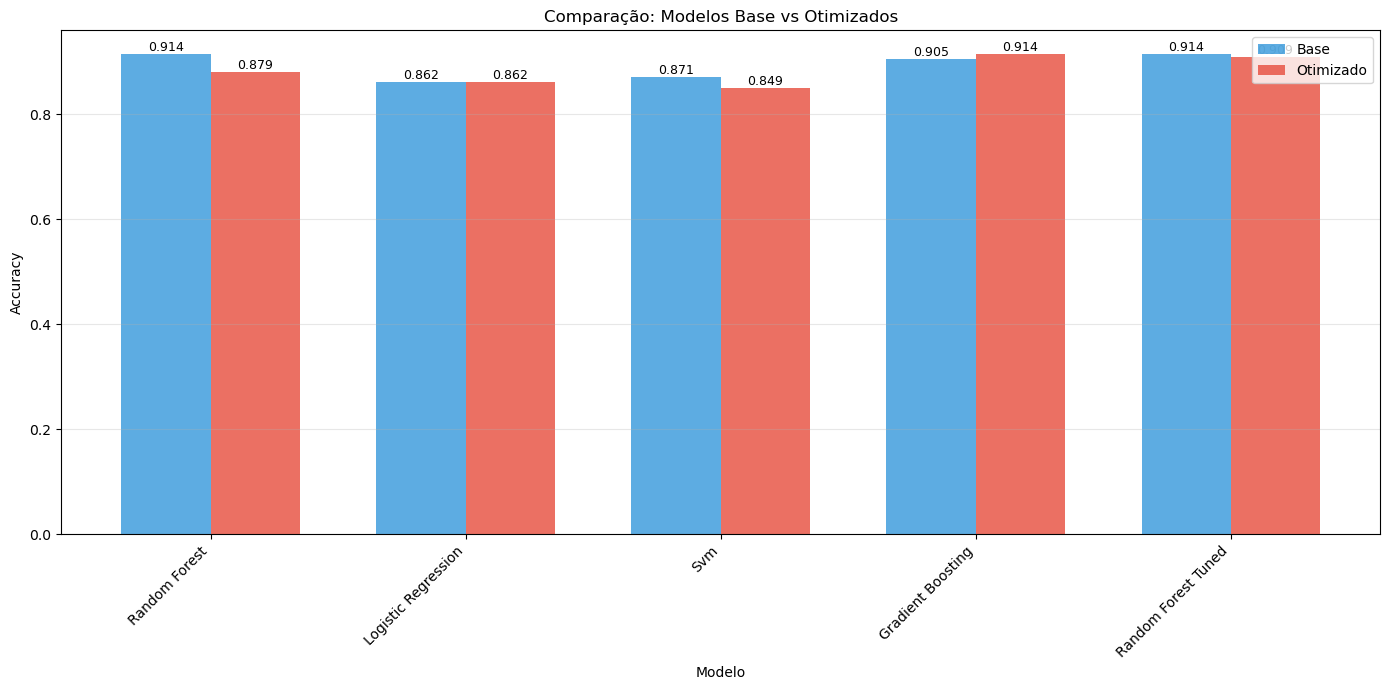

In [12]:
if len(results_base) > 0 and len(results_tuned) > 0:
    comparison_data = []

    # Mapear modelos base para seus otimizados
    model_mapping = {
        'random_forest': 'random_forest_optimized',
        'logistic_regression': 'logistic_regression_optimized',
        'svm': 'svm_optimized',
        'gradient_boosting': 'gradient_boosting_optimized',
        'random_forest_tuned': 'random_forest_tuned_v2'
    }

    for base in results_base:
        base_name = base['model_name']
        optimized_name = model_mapping.get(base_name)
        
        if optimized_name:
            tuned = next((r for r in results_tuned if r['model_name'] == optimized_name), None)
            
            if tuned:
                comparison_data.append({
                    'Model': base_name.replace('_', ' ').title(),
                    'Base Accuracy': base['accuracy'],
                    'Tuned Accuracy': tuned['accuracy'],
                    'Improvement': tuned['accuracy'] - base['accuracy'],
                    'Improvement %': (tuned['accuracy'] - base['accuracy']) / base['accuracy'] * 100
                })

    comparison_df = pd.DataFrame(comparison_data)

    print("\n📊 Comparação Base vs Otimizado:")
    display(comparison_df)

    # %% Visualizar comparação
    if len(comparison_df) > 0:
        fig, ax = plt.subplots(figsize=(14, 7))

        x = np.arange(len(comparison_df))
        width = 0.35

        bars1 = ax.bar(x - width/2, comparison_df['Base Accuracy'], width, 
                       label='Base', color='#3498db', alpha=0.8)
        bars2 = ax.bar(x + width/2, comparison_df['Tuned Accuracy'], width,
                       label='Otimizado', color='#e74c3c', alpha=0.8)

        ax.set_xlabel('Modelo')
        ax.set_ylabel('Accuracy')
        ax.set_title('Comparação: Modelos Base vs Otimizados')
        ax.set_xticks(x)
        ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

        # Adicionar valores nas barras
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.3f}',
                        ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.show()
else:
    print("⚠️ Não foi possível comparar modelos - verifique se os modelos base foram carregados")

# Predições no Conjunto de Validação

In [13]:
# %% Selecionar melhor modelo
best_tuned = max(results_tuned, key=lambda x: x['accuracy'])
best_model_name = best_tuned['model_name']
best_accuracy = best_tuned['accuracy']

print(f"\n🏆 Melhor modelo otimizado: {best_model_name}")
print(f"   Accuracy: {best_accuracy:.4f}")

# Carregar melhor modelo
best_model = tuned_models[best_model_name]

# %% Predições no conjunto de validação
print("\n🔄 Realizando predições no conjunto de validação...")

y_val_pred = best_model.predict(X_val)
y_val_pred_proba = best_model.predict_proba(X_val) if hasattr(best_model, 'predict_proba') else None

# Avaliar
val_metrics = evaluator.evaluate_model(
    y_val, 
    y_val_pred, 
    y_val_pred_proba,
    model_name=f"{best_model_name}_validation"
)

print(f"\n📊 Resultados no Conjunto de Validação:")
print(f"   Accuracy:  {val_metrics['accuracy']:.4f}")
print(f"   Precision: {val_metrics['precision']:.4f}")
print(f"   Recall:    {val_metrics['recall']:.4f}")
print(f"   F1-Score:  {val_metrics['f1_score']:.4f}")

INFO:src.model_evaluation:📊 Avaliando modelo: gradient_boosting_optimized_validation
INFO:src.model_evaluation:✅ Accuracy: 0.9251
INFO:src.model_evaluation:✅ Precision: 0.9251
INFO:src.model_evaluation:✅ Recall: 0.9251
INFO:src.model_evaluation:✅ F1-Score: 0.9251
INFO:src.model_evaluation:✅ ROC AUC: 0.9600



🏆 Melhor modelo otimizado: gradient_boosting_optimized
   Accuracy: 0.9138

🔄 Realizando predições no conjunto de validação...

📊 Resultados no Conjunto de Validação:
   Accuracy:  0.9251
   Precision: 0.9251
   Recall:    0.9251
   F1-Score:  0.9251


INFO:src.model_evaluation:📊 Matriz de Confusão:
[[ 98   9]
 [  8 112]]


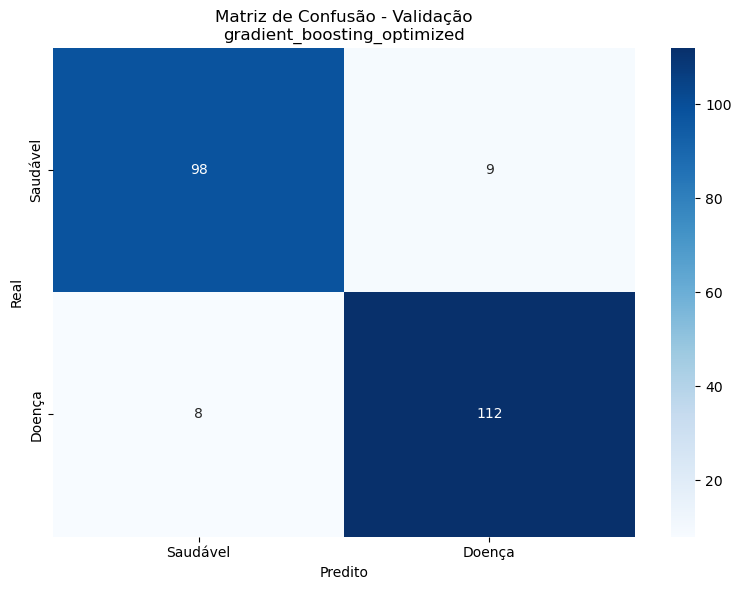

In [14]:
cm_val = evaluator.get_confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Saudável', 'Doença'],
           yticklabels=['Saudável', 'Doença'])
plt.title(f'Matriz de Confusão - Validação\n{best_model_name}')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.tight_layout()
plt.show()

# Salvar predições e Modelo Final

In [15]:
predictions_df = pd.DataFrame({
    'patient_id': range(len(y_val)),
    'true_label': y_val.values,
    'predicted_label': y_val_pred,
    'probability_disease': y_val_pred_proba[:, 1] if y_val_pred_proba is not None else y_val_pred,
    'correct': y_val.values == y_val_pred
})

print("\n📊 Primeiras predições:")
display(predictions_df.head(10))


📊 Primeiras predições:


,patient_id,true_label,predicted_label,probability_disease,correct
0,0,1,1,1.000000e+00,True
1,1,0,0,2.634889e-04,True
2,2,1,1,9.999998e-01,True
3,3,0,0,1.976143e-07,True
4,4,0,0,9.905073e-10,True
5,5,1,1,9.469659e-01,True
6,6,0,0,6.347426e-09,True
7,7,0,0,4.610390e-07,True
8,8,0,0,9.307792e-11,True
9,9,1,1,1.000000e+00,True


In [16]:
# Estatísticas
correct_count = predictions_df['correct'].sum()
total_count = len(predictions_df)

print(f"\n✅ Predições corretas: {correct_count}/{total_count} ({correct_count/total_count*100:.1f}%)")


✅ Predições corretas: 210/227 (92.5%)


In [17]:
# %% Salvar predições no MinIO
s3.write_csv(predictions_df, 'predictions/validation_predictions.csv')
print("\n✅ Predições salvas no MinIO!")

INFO:src.s3_utils:✅ CSV salvo: s3://ml-bucket-heart/predictions/validation_predictions.csv



✅ Predições salvas no MinIO!


In [18]:
# %% Salvar modelo final otimizado como "production"
production_model_id = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
production_model_path = f'models/production_model/{production_model_id}/model.pkl'

s3.save_model(best_model, production_model_path)
print(f"\n✅ Modelo de produção salvo: {production_model_path}")

INFO:src.s3_utils:✅ Modelo salvo: s3://ml-bucket-heart/models/production_model/20251201_231253/model.pkl



✅ Modelo de produção salvo: models/production_model/20251201_231253/model.pkl


In [19]:
# Salvar metadados do modelo de produção
# Identificar qual parâmetro usar baseado no nome do modelo
if 'random_forest' in best_model_name:
    if 'v2' in best_model_name:
        best_params_used = rf_v2_best_params
    else:
        best_params_used = rf_best_params
elif 'logistic' in best_model_name:
    best_params_used = lr_best_params
elif 'svm' in best_model_name:
    best_params_used = svm_best_params
elif 'gradient' in best_model_name:
    best_params_used = gb_best_params
else:
    best_params_used = {}

production_metadata = {
    'model_name': best_model_name,
    'model_path': production_model_path,
    'timestamp': production_model_id,
    'test_accuracy': best_accuracy,
    'validation_accuracy': val_metrics['accuracy'],
    'best_params': str(best_params_used)  # Converter dict para string
}

production_metadata_df = pd.DataFrame([production_metadata])
s3.write_csv(production_metadata_df, 'models/production_model_metadata.csv')
print("✅ Metadados do modelo de produção salvos!")

INFO:src.s3_utils:✅ CSV salvo: s3://ml-bucket-heart/models/production_model_metadata.csv


✅ Metadados do modelo de produção salvos!


# Resumo Final

In [20]:
# %% Resumo completo
print("\n" + "="*60)
print("📊 RESUMO FINAL DO PROJETO")
print("="*60)

if len(results_base) > 0:
    print("\n🎯 MODELOS BASE (Artigo):")
    for result in results_base:
        print(f"   {result['model_name']}: {result['accuracy']:.4f}")

print("\n🚀 MODELOS OTIMIZADOS:")
for result in results_tuned:
    print(f"   {result['model_name']}: {result['accuracy']:.4f}")

print(f"\n🏆 MELHOR MODELO: {best_model_name}")
print(f"   Test Accuracy:       {best_accuracy:.4f}")
print(f"   Validation Accuracy: {val_metrics['accuracy']:.4f}")

if len(comparison_data) > 0:
    print(f"\n📈 MELHORIA MÉDIA: {comparison_df['Improvement %'].mean():.2f}%")

print(f"\n💾 MODELO DE PRODUÇÃO:")
print(f"   Path: {production_model_path}")
print(f"   Timestamp: {production_model_id}")

print("\n✅ PROJETO CONCLUÍDO!")
print("="*60)


📊 RESUMO FINAL DO PROJETO

🎯 MODELOS BASE (Artigo):
   random_forest: 0.9138
   logistic_regression: 0.8621
   svm: 0.8707
   gradient_boosting: 0.9052
   random_forest_tuned: 0.9138

🚀 MODELOS OTIMIZADOS:
   random_forest_optimized: 0.8793
   logistic_regression_optimized: 0.8621
   svm_optimized: 0.8491
   gradient_boosting_optimized: 0.9138
   random_forest_tuned_v2: 0.9095

🏆 MELHOR MODELO: gradient_boosting_optimized
   Test Accuracy:       0.9138
   Validation Accuracy: 0.9251

📈 MELHORIA MÉDIA: -1.15%

💾 MODELO DE PRODUÇÃO:
   Path: models/production_model/20251201_231253/model.pkl
   Timestamp: 20251201_231253

✅ PROJETO CONCLUÍDO!


In [21]:
# %% Exportar resumo completo
summary_data = {
    'project': 'Heart Disease Prediction',
    'best_model': best_model_name,
    'test_accuracy': best_accuracy,
    'validation_accuracy': val_metrics['accuracy'],
    'production_model_path': production_model_path,
    'timestamp': production_model_id,
    'total_models_trained': len(results_base) + len(results_tuned),
    'average_improvement': comparison_df['Improvement %'].mean() if len(comparison_data) > 0 else 0
}

summary_df = pd.DataFrame([summary_data])
s3.write_csv(summary_df, 'models/project_summary.csv')
print("\n✅ Resumo do projeto exportado para MinIO!")

INFO:src.s3_utils:✅ CSV salvo: s3://ml-bucket-heart/models/project_summary.csv



✅ Resumo do projeto exportado para MinIO!
